In [ ]:
!pip install catboost

In [ ]:
import requests
import pandas as pd
import numpy as np
import hashlib
from sklearn import preprocessing
from collections import defaultdict
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

train_df = pd.read_csv("https://gitlab.com/tigrulya-exe/sales-prediction/-/raw/master/data/train.csv")

In [ ]:
def transform_seller(seller):
    value = seller
    if ("доставка OZON" in seller):
        value = seller.replace("доставка OZON", "")
    elif ("OZON" != seller and "OZON" in seller):
        value = seller.replace("OZON", "")
    
    return value[:-1] if value[-1] == ',' else value

def prepare_data(df_in, isTrain=True, cols=['Brand', 'Deliveryscheme', 'Comments', 'Rating', 'Average price', 
            'Seller', 'Days in stock', 'cat_meta', 'cat_sub', 'Sales', 'isNotIp', 'isNotOOO', 'Price']):
    
    df = df_in[~pd.to_numeric(df_in['Days in stock'], errors='coerce').isna()]
    df = df.loc[df.Price != 0]
    df['Days in stock'] = df['Days in stock'].astype(float)
    df['Days in stock'] = df['Days in stock'].astype(int)
    df.Rating = df_in.Rating.str.replace(',', '.').astype(float)

    df = pd.concat([df, df.Category.str.split('/', expand=True)\
                .rename(columns={0: 'cat_meta', 1: 'cat_sub', 2: 'cat_sub_sub'})], axis=1)

    df['Seller'].fillna('NoSeller', inplace=True)
    df.Seller = df.Seller.transform(transform_seller)
    df['Brand'].fillna(df['Seller'], inplace=True)
    df['cat_meta'].fillna('NoCategory', inplace=True)
    df['cat_sub'].fillna(df['cat_meta'], inplace=True)

    df['Average price'].fillna(0, inplace=True)

    df['isNotIp'] = df.Seller.where(df.Seller.str.contains("ИП")).isna().astype(int)
    df['isNotOOO'] = df.Seller.where(df.Seller.str.contains("ООО")).isna().astype(int)

    if (isTrain):
        df['Sales'] = df['Sales'].astype(int)

    return df[cols]

In [ ]:
prepared_train_df = prepare_data(train_df, True)
prepared_train_df.info()

In [ ]:
train_df_sampled = prepared_train_df.copy()

X_train, X_test, y_train, y_test = train_test_split(train_df_sampled.drop(columns='Sales'), train_df_sampled.Sales)
X_train = train_df_sampled.drop(columns=['Sales'])
y_train = train_df_sampled.Sales

In [ ]:
from catboost import CatBoostRegressor, Pool

category_features = [0, 1, 5, 7, 8]
model = CatBoostRegressor(
    n_estimators=900,
    task_type="GPU",
    border_count=254,
    depth=11,
    cat_features=category_features,
    # random_strength=0.5,
    learning_rate=0.19,
    verbose=50,
    l2_leaf_reg=1,
    # per_float_feature_quantization='3:border_count=10',
)

model.fit(X_train, y_train, use_best_model=True, eval_set=Pool(X_test, y_test, cat_features=category_features))

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(f'MAE train: {mean_absolute_error(y_train, y_pred_train)}, MAE test: {mean_absolute_error(y_test, y_pred_test)}')
print(f'MSE train: {mean_squared_error(y_train, y_pred_train)}, MSE test: {mean_squared_error(y_test, y_pred_test)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_pred_train)}, MAPE test: {mean_absolute_percentage_error(y_test, y_pred_test)}')

In [ ]:
# from google.colab import files
from numpy import round

test_df = pd.read_csv("https://gitlab.com/tigrulya-exe/sales-prediction/-/raw/master/data/test.csv")
prepared_test_df = prepare_data(test_df, isTrain=False, cols=['Brand', 'Deliveryscheme', 'Comments', 'Rating', 'Average price', 
            'Seller', 'Days in stock', 'cat_meta', 'cat_sub', 'isNotIp', 'isNotOOO', 'Price'])
predicted = model.predict(prepared_test_df)
predicted = np.where(predicted < 0, 0, predicted)

result = pd.DataFrame(data=round(predicted))
result = result.rename(columns={0: 'Expected'})
result.loc[prepared_test_df['Average price'] == 0, 'Expected'] = 0

filename = 'result.csv'
result.index.name = 'Id'
result.to_csv(filename)
# files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

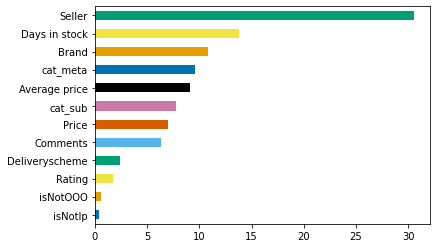

In [ ]:
from bokeh.palettes import Colorblind8

pd.Series(model.feature_importances_, index=X_train.columns)\
    .sort_values().plot.barh(color=Colorblind8);

In [ ]:
plot_df = pd.DataFrame(y_train).copy()
plot_df['pred'] = y_pred_train
plot_df

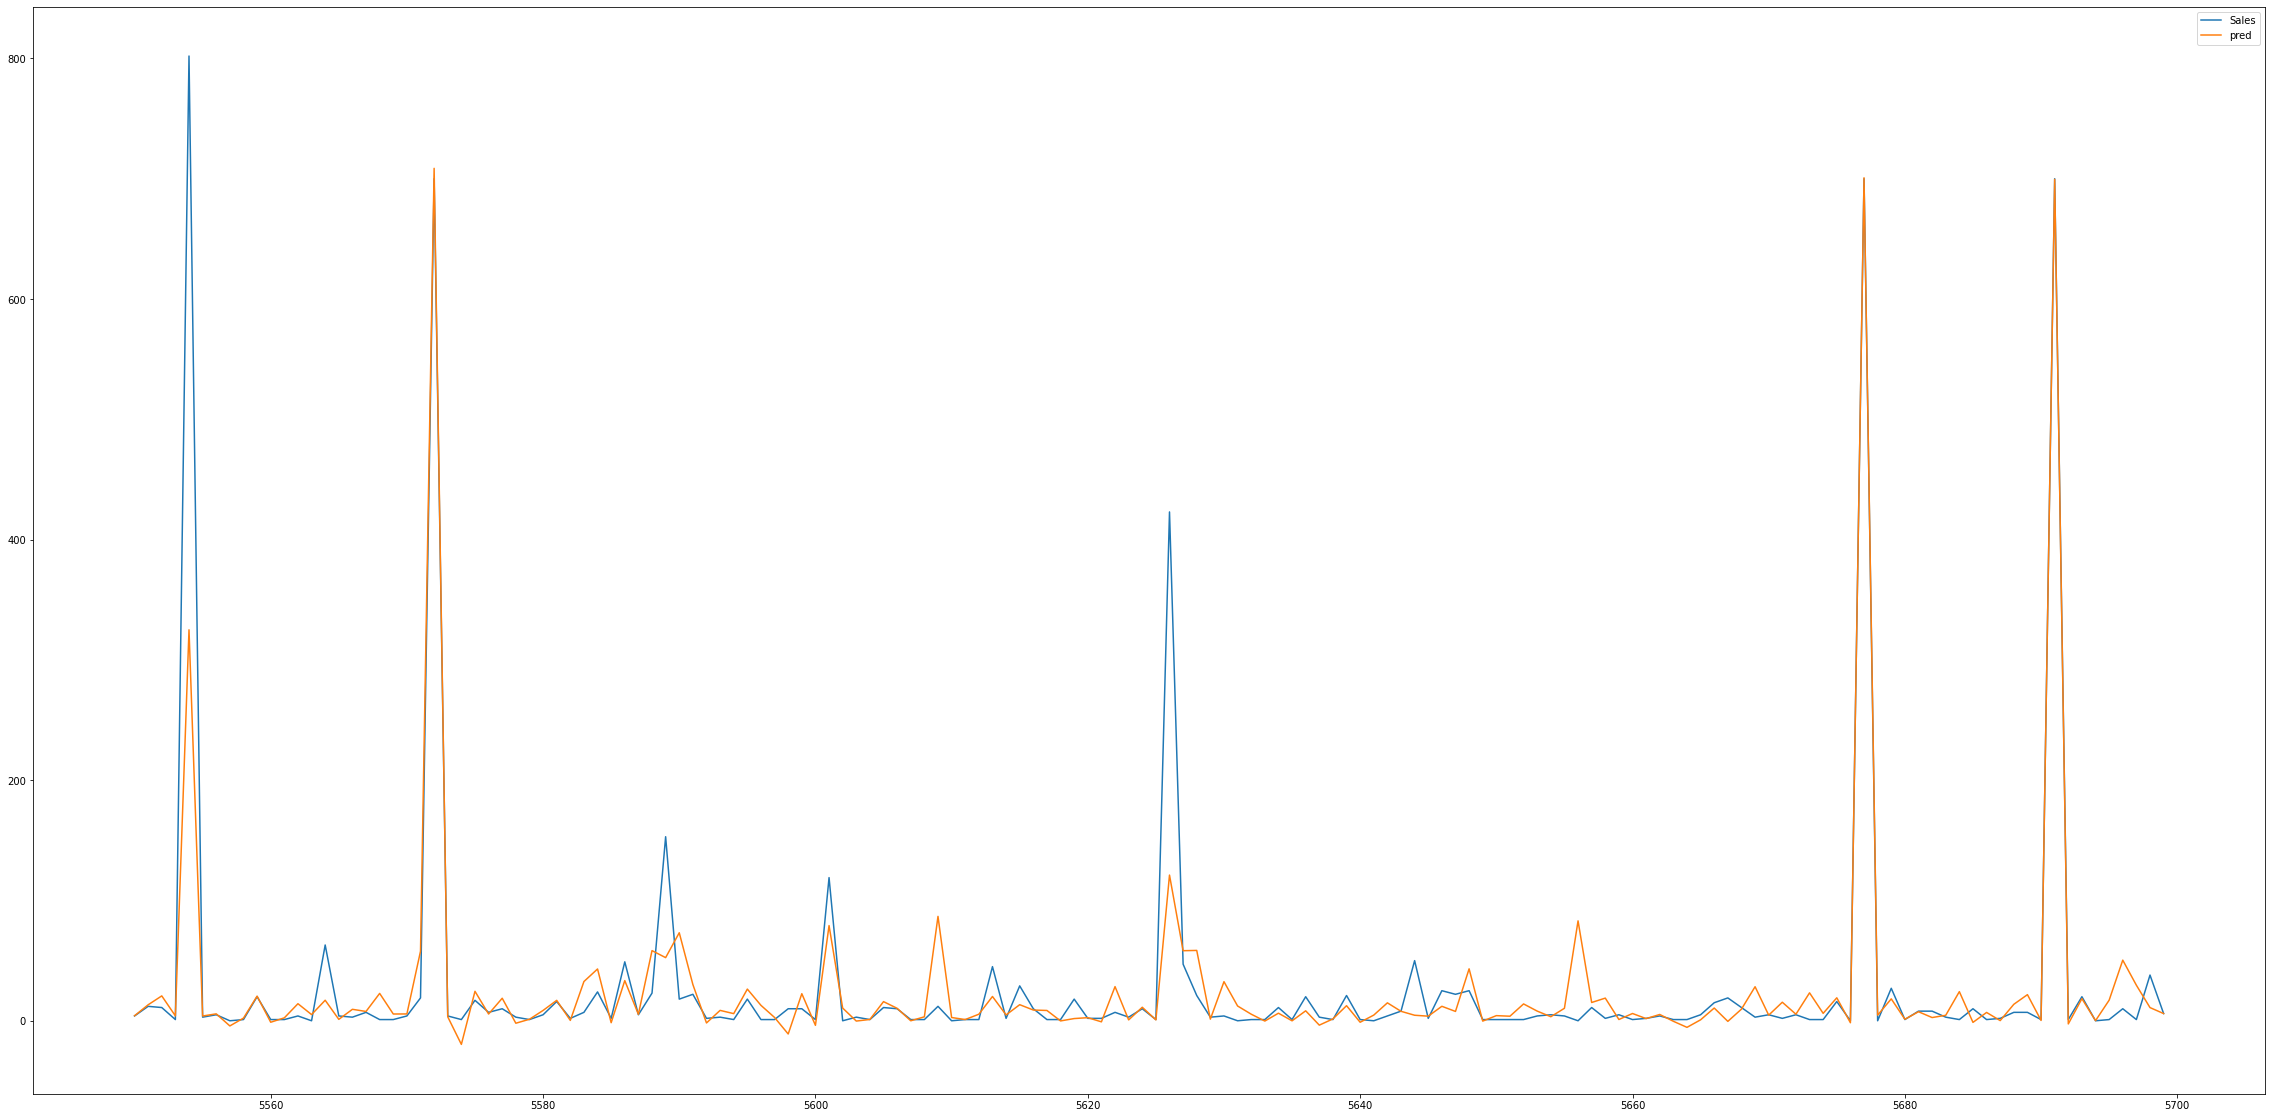

In [ ]:
plot_df[5550:5700].plot(figsize=(40, 20))
# pd.DataFrame(y_pred_train[:100]).plot(color='orange')